# Histogrammar and Functional Programming HATS

Last week, John and Mauro introduced PyROOT and rootpy, two Python interfaces to ROOT. Along the way, they showed some of the advantages of using a high-level scripting language for data analysis.

In this tutorial, I'll be presenting Histogrammar first as a way to speed up a PyROOT analysis (John's in particular) without leaving Python, then as a general introduction to functional programming for data analysis.

# Introduction: PyROOT acceleration

No programming language is good at everything. John showed you how Python simplifies the organizational part of a data analysis, but for heavy number crunching, C++ is much faster. This is widely acknowledged: the Scientific Python ecosystem (which I'll be showing tomorrow) is mostly written in C++ with Pythonic bindings.

John's recommendation is a good one:

   * use C++ for a focused, fast routine that does one thing in a streamlined way, and
   * use Python for everything else, gluing together the different parts of your analysis.

His example used MakeClass to build a C++ iterator over TTrees, and he controlled that iterator from Python. But as you saw, generating an iterator with MakeClass, compiling it, and switching between C++ and Python is cumbersome.

To motivate Histogrammar, let's see how it simplifies this bridge by letting you inject little C++ snippets in the midst of Python, for the sake of filling histograms quickly.

First, we import ROOT as before.

In [1]:
import time
import ROOT
tcanvas = ROOT.TCanvas("TCanvasName", "TCanvasTitle", 800, 300)

Welcome to JupyROOT 6.08/04


Now let's get some of John's data. We could access this directly in PyROOT using the "root://" file URLs, but we'll be focusing on performance and I found that performance numbers are more stable when you don't mix in network bandwidth.

These files add up to 220 MB; shouldn't break your quota. If you re-run this cell, `xrdcp` will complain that the file is already there (which is fine).

In [2]:
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_0.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_1.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_2.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_3.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_4.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_5.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_6.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_7.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_8.root .
!xrdcp root://cmseos.fnal.gov//store/user/hats/PyRoot/2017/qcd_samples/shuffled_sig/sig_shuffled_9.root .

[22.04MB/22.04MB][100%][==================================================][22.04MB/s]  
[22.09MB/22.09MB][100%][==================================================][22.09MB/s]  
[22.13MB/22.13MB][100%][==================================================][22.13MB/s]  
[22.1MB/22.1MB][100%][==================================================][22.1MB/s]  
[22.09MB/22.09MB][100%][==================================================][22.09MB/s]  
[22.08MB/22.08MB][100%][==================================================][22.08MB/s]  
[22.07MB/22.07MB][100%][==================================================][22.07MB/s]  
[22.11MB/22.11MB][100%][==================================================][22.11MB/s]  
[22.12MB/22.12MB][100%][==================================================][22.12MB/s]  
[22.15MB/22.15MB][100%][==================================================][22.15MB/s]  


Now we make a TChain of these files and take a quick look at their branches.

In [2]:
tchain = ROOT.TChain()
tchain.Add("sig_shuffled_0.root/tree")
tchain.Add("sig_shuffled_1.root/tree")
tchain.Add("sig_shuffled_2.root/tree")
tchain.Add("sig_shuffled_3.root/tree")
tchain.Add("sig_shuffled_4.root/tree")
tchain.Add("sig_shuffled_5.root/tree")
tchain.Add("sig_shuffled_6.root/tree")
tchain.Add("sig_shuffled_7.root/tree")
tchain.Add("sig_shuffled_8.root/tree")
tchain.Add("sig_shuffled_9.root/tree")
list(tchain.GetListOfBranches())

[<ROOT.TBranch object ("ph_N") at 0x5cb8ad0>,
 <ROOT.TBranchElement object ("ph_pdgId") at 0x5cc34f0>,
 <ROOT.TBranchElement object ("ph_charge") at 0x5ccb650>,
 <ROOT.TBranchElement object ("ph_e") at 0x5ccbd40>,
 <ROOT.TBranchElement object ("ph_eta") at 0x5ccc430>,
 <ROOT.TBranchElement object ("ph_phi") at 0x5cccb20>,
 <ROOT.TBranchElement object ("ph_mass") at 0x5ccd210>,
 <ROOT.TBranchElement object ("ph_pt") at 0x5ccd900>,
 <ROOT.TBranchElement object ("ph_et") at 0x5ccdff0>,
 <ROOT.TBranchElement object ("ph_rho") at 0x5cce6e0>,
 <ROOT.TBranchElement object ("ph_superCluster_eta") at 0x5ccedd0>,
 <ROOT.TBranchElement object ("ph_superCluster_phi") at 0x5ccf580>,
 <ROOT.TBranchElement object ("ph_sigmaIetaIeta") at 0x5ccfd30>,
 <ROOT.TBranchElement object ("ph_hOverE") at 0x5cd04e0>,
 <ROOT.TBranchElement object ("ph_isoGamma") at 0x5cd0bd0>,
 <ROOT.TBranchElement object ("ph_isoCh") at 0x5cd12c0>,
 <ROOT.TBranchElement object ("ph_passEleVeto") at 0x5cd19b0>,
 <ROOT.TBranchElem

In [6]:
from histogrammar import *

histogram = Bin(100, 0, 1000, lambda x: x)    # we'll explain this "lambda x: x" in a moment

startTime = time.time()
for event in tchain:
    if event.jetAK4_N > 0:
        histogram.fill(event.jetAK4_pt[0])
endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 24.045511961 seconds.


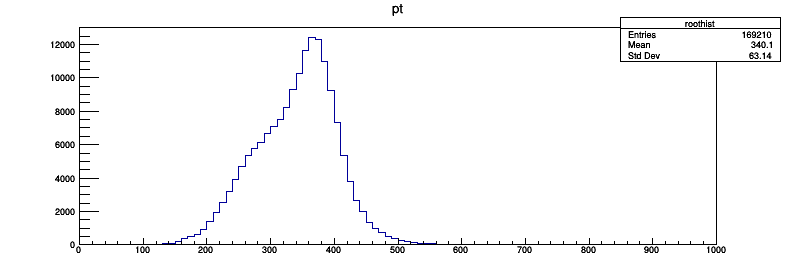

In [8]:
roothist = histogram.plot.root("roothist", "pt")
roothist.Draw()
tcanvas.Draw()

This took 1.87890481949 seconds.


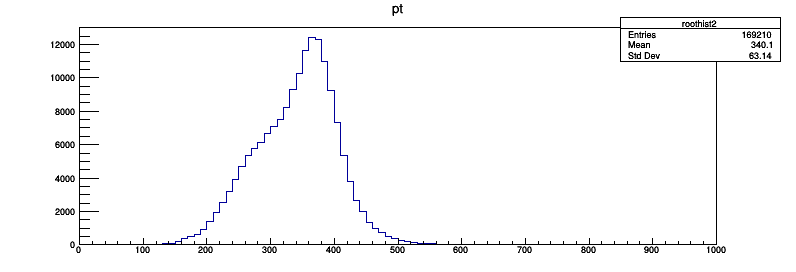

In [9]:
histogram = Select("jetAK4_N > 0", Bin(100, 0, 1000, "jetAK4_pt[0]"))

startTime = time.time()
histogram.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds."

roothist2 = histogram.plot.root("roothist2", "pt")
roothist2.Draw()
tcanvas.Draw()

In [4]:
tchain.SetBranchStatus("*", 0)
for branch in ["jetAK4_N",
               "jetAK4_pt",
               "jetAK4_eta",
               "jetAK4_mass",
               "jetAK4_phi",
               "jetAK4_e",
               "jetAK4_jec",
               "jetAK4_IDLoose"]:
    tchain.SetBranchStatus(branch, 1)

In [5]:
dijetMass_hist = ROOT.TH1D("dijetMass_hist", "dijet mass [GeV]", 100, 0, 1000)
dijetEtBalance_hist = ROOT.TH1D("dijetEtBalance_hist", "dijet ET balance", 100, 0, 1)
cosThetaStar_hist = ROOT.TH1D("cosThetaStar_hist", "cos(theta*)", 100, -1, 1)

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    dijet = leadingJet + subleadingJet

    boostedLeadingJet = leadingJet
    boostedLeadingJet.Boost(-dijet.BoostVector())
    
    dijetMass_hist.Fill(dijet.M())
    dijetEtBalance_hist.Fill(subleadingJet.Et() / leadingJet.Et())
    cosThetaStar_hist.Fill(boostedLeadingJet.Pz() / boostedLeadingJet.P())

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 21.2750182152 seconds.


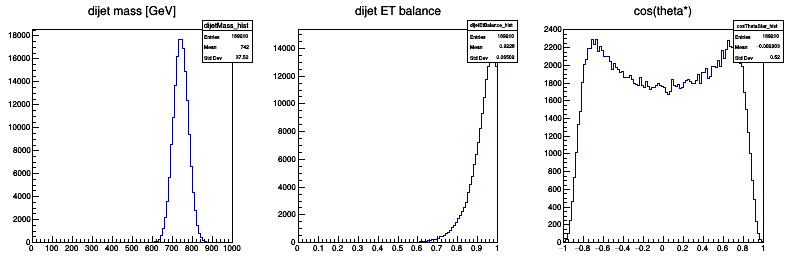

In [6]:
tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

In [7]:
Bundle = UntypedLabel    # a naming convention we'll be changing to in Histogrammar 2.0

def cosThetaStar(jets):
    boostedLeading = jets[0]
    boostedLeading.Boost(-(jets[0] + jets[1]).BoostVector())
    return boostedLeading.Pz() / boostedLeading.P()

histograms = Bundle(
    dijetMass      = Bin(100, 0, 1000, lambda jets: (jets[0] + jets[1]).M()),
    dijetEtBalance = Bin(100, 0, 1, lambda jets: jets[1].Et() / jets[0].Et()),
    cosThetaStar   = Bin(100, -1, 1, cosThetaStar))

leadingJet = ROOT.TLorentzVector()
subleadingJet = ROOT.TLorentzVector()

startTime = time.time()
for event in tchain:
    if event.jetAK4_N < 2:
        continue
    
    leadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(0),
                            event.jetAK4_eta.at(0),
                            event.jetAK4_phi.at(0),
                            event.jetAK4_e.at(0))
    
    subleadingJet.SetPtEtaPhiE(event.jetAK4_pt.at(1),
                               event.jetAK4_eta.at(1),
                               event.jetAK4_phi.at(1),
                               event.jetAK4_e.at(1))
    
    histograms.fill([leadingJet, subleadingJet])

endTime = time.time()

print "This took", endTime - startTime, "seconds."

This took 34.4799318314 seconds.


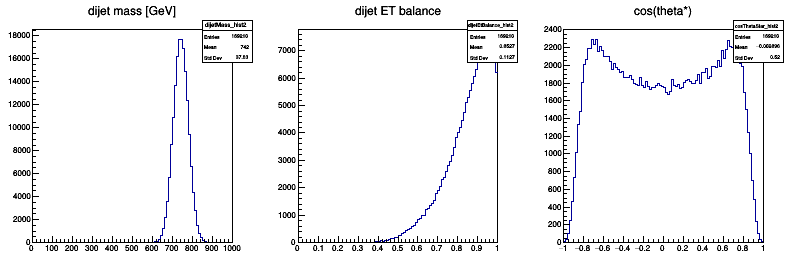

In [8]:
dijetMass_hist2 = histograms.get("dijetMass").plot.root("dijetMass_hist2", "dijet mass [GeV]")
dijetEtBalance_hist2 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist2", "dijet ET balance")
cosThetaStar_hist2 = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist2", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist2.Draw()
tcanvas.cd(2); dijetEtBalance_hist2.Draw()
tcanvas.cd(3); cosThetaStar_hist2.Draw()
tcanvas.Draw()

In [9]:
# yes, we're creating new TLorentzVectors, but on the stack, which is faster than allocation with "new"
ROOT.gInterpreter.Declare("""
TLorentzVector lorentzVector(int i, vector<float>& pt, vector<float>& eta, vector<float>& phi, vector<float>& e) {
    TLorentzVector out;
    out.SetPtEtaPhiE(pt.at(i), eta.at(i), phi.at(i), e.at(i));
    return out;
}
""")

ROOT.gInterpreter.Declare("""
double cosThetaStar(TLorentzVector leadingJet, TLorentzVector subleadingJet) {
    leadingJet.Boost(-(leadingJet + subleadingJet).BoostVector());
    return leadingJet.Pz() / leadingJet.P();
}
""")

True

In [10]:
histograms = Select("jetAK4_N >= 2", Bundle(
    dijetMass = Bin(100, 0, 1000, """
        (lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e) +
         lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e)
        ).M()
    """),
    dijetEtBalance = Bin(100, 0, 1, """
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et() /
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e).Et()
    """),
    cosThetaStar   = Bin(100, -1, 1, """cosThetaStar(
        lorentzVector(0, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e),
        lorentzVector(1, jetAK4_pt, jetAK4_eta, jetAK4_phi, jetAK4_e))""")
))

startTime = time.time()
histograms.fill.root(tchain)
endTime = time.time()

print "This took", endTime - startTime, "seconds (including compilation)."

This took 1.86146497726 seconds (including compilation).


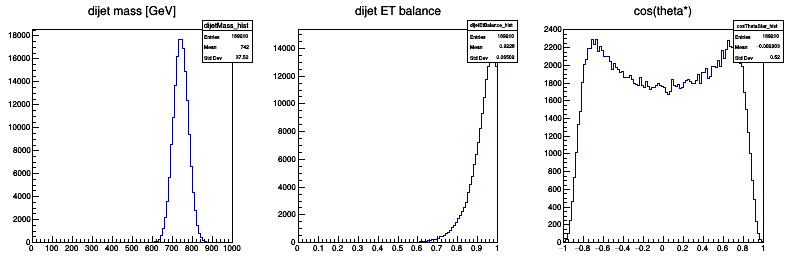

In [11]:
dijetMass_hist3 = histograms.get("dijetMass").plot.root("dijetMass_hist3", "dijet mass [GeV]")
dijetEtBalance_hist3 = histograms.get("dijetEtBalance").plot.root("dijetEtBalance_hist3", "dijet ET balance")
cosThetaStar_hist3 = histograms.get("cosThetaStar").plot.root("cosThetaStar_hist3", "cos(theta*)")

tcanvas.Clear()
tcanvas.Divide(3, 1)

tcanvas.cd(1); dijetMass_hist.Draw()
tcanvas.cd(2); dijetEtBalance_hist.Draw()
tcanvas.cd(3); cosThetaStar_hist.Draw()
tcanvas.Draw()

In [12]:
!root -l rootmacro.C++

root [0] 
Processing rootmacro.C++...
Info in <TUnixSystem::ACLiC>: creating shared library /uscms_data/d2/pivarski/CMSSW_9_0_1/src/scientific-python-hats/histogrammar/./rootmacro_C.so
This took 1.56078 seconds.
